# Using pyplume with discharge timeseries

This example demonstrates how pyplume can be used with discharge timeseries to calculate how the plume behaves on seasonal timescales. This example also demonstrates a method which can be used to estimate plume driven upwelling, as described in Halbach et al. (submitted).

First of all, do some generic imports and set matplotlib as inline since we're in a jupyter notebook.

In [1]:
import math
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

And some more specific imports. We'll use the **gsw** package to make it easy to calculate water properties like density using the latest TEOS-10 standard. And of course, we need **pyplume** too. In this case we also pull in *const* which contains the constants which **pyplume** uses so we can use the same ones in the analytical solution.

In [2]:
import gsw

# This is necessary in binder 
# Or if pyplume isn't in your pythonpath and you launched the notebook from the examples directory
import sys
sys.path.append('..')
import pyplume, const

# If pyplume is a package in your python path, you should use this line instead:
#from pyplume import pyplume, const

## Model Setup

Let's set up the model for a Kronebreen-like environment.

First off, the ocean is around 70 metres deep at the terminus of the Kronebreen.

In [3]:
h_w = 70.

And the ice is about 100 metres thick at the terminus (so the glacier stands about 30 metres above the ocean surface).

In [4]:
h_i = 100.

The ambient ocean conditions here are taken from CTD data collected in 2016, close to the terminus of Kronebreen. Profiles close to the terminus (but not within the plume) were spatially averaged to produce the profile. 

The profile was generated using the script in the **alistaireverett/ctdtools** repository using [this script](https://github.com/alistaireverett/ctdtools/blob/master/examples/proc_cnv_short.py). The csv contains columns with depth (metres) or pressure (dbar), temperature ($^\circ$C), and salinity (kg/m$^3$). Check the docstring for *pyplume.Ambient* for more details.

In [5]:
# load the csv file into a dataframe with pandas
amb_df = pd.read_csv('ambient.csv',';')

# create an ambient profile object from the data in the csv file
ambient = pyplume.Ambient(h_w, amb_df['SA'], amb_df['CT'], depth=amb_df['depth'])

Now we can load the discharges. For this example we'll use a synthetic set of discharges which simply use a gaussian distribution to represent a discharge which varies from 0 m$^3$/s to 100 m$^3$/s and back to 0 m$^3$/s during July 2017 (obviously not a very realisitic situation!).

The discharge is loaded from a csv file which contains the following columns:
Year, Month, Day and Discharge (m3/s).

In [6]:
disch_data = pd.read_csv('discharges.csv',';')

def to_dt(x):
    """
    Function to convert Y/M/D/H columns to python datetime object

    """
    return dt.datetime(int(x['year']),int(x['month']),int(x['day']))

# Add pandas datetime column using date conversion function
disch_data['date'] = disch_data.apply(to_dt,axis=1)

**pyplume** requires the radius and velocity at the inlet, so we can use the *pyplume.inlet()* method to calcuate these for all of the discharges which we just loaded. (The method used here follows [Slater et al. (2015)](http://dx.doi.org/10.1002/2014GL062494) / [Schoof (2010)](https://doi.org/10.1038/nature09618)).

In [7]:
rad, vel = pyplume.inlet(h_i, h_w, disch_data['discharge'])

# Add to new columns of DataFrame
disch_data['src_radius'] = rad
disch_data['src_vel'] = vel

## Run the model

Now we can loop through all of the inlet properties and calculate a steady state solution for each given discharge (now defined by inlet radius and velocity). If you're running in binder it will take a few minutes, but be patient ;).

In [8]:
# initialise an empty list to store results
res_data = []

for r, u in disch_data[["src_radius","src_vel"]].values:
    # The key line -  get steady state plume solution for given inputs
    out = pyplume.calc_plume(u, r, h_w, ambient, MELT=True)
    
    # convert the lists in the returned dict to numpy arrays 
    out = {k: np.array(out[k]) for k in out.keys()}

    # append to results
    res_data.append(out)

## Results

The results need a little post-processing here to calculate the volume and entrainment fluxes in the plume. We can also pull out the neutral buoyancy height. 

Some of this looks a little messy and complicated, but this is mostly because we're applying this to a complicated data structure and we need to calculate the results at each timestep individually. There are certainly more verbose ways of doing this, but the methods here are designed to be concise but understandable.

In [9]:
# append the results to a new column in the discharge dataframe
disch_data['results'] = res_data

# calculate plume density profile from temp, sal and pressure
disch_data['plume_density'] = disch_data['results'].apply(lambda x: gsw.rho(x['s_p'],x['t_p'],ambient.get_pres_z(x['z'])))

# Define a function to extract volume at a given depth
def vol_flux_at_depth(data, height_above_source):
    vol_flux = 0.5 * math.pi * data['b_p']**2. * data['u_p']
    vol_flux_out = vol_flux[data['z']==height_above_source]
    return vol_flux_out[0]

# apply function to get vol flux one metre below the surface
disch_data['vol_flux'] = disch_data['results'].apply(vol_flux_at_depth, height_above_source = h_w - 1.)

# calculate difference between surface flux and discharge as entrained flux
disch_data['ent_flux'] = disch_data['vol_flux'] - disch_data['discharge']

# calc_plume returns NaN if the plume is above the neutral buoyancy height
# so extract nb_height as the max height where the plume radius is not NaN
disch_data['nb_depth'] = disch_data['results'].apply(lambda x: max(x['z'][~np.isnan(x['b_p'])]))


We can now make a nice video of the results through the synthetic time series we created...

From a plume perspective, note how the entrainment rate is non-linearly related to the discharge, and that entrainment is not calculated if the plume doesn't reach the surface.

In [10]:
from matplotlib import animation
import matplotlib.gridspec as gridspec
from IPython.display import HTML

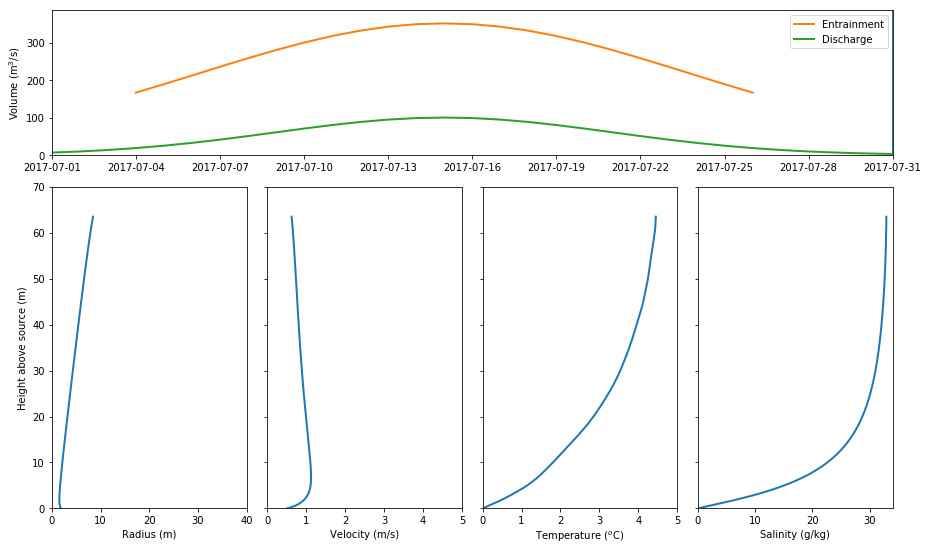

In [11]:
# set up the figure layout
fig = plt.figure(figsize=(13,8))
gs = gridspec.GridSpec(3, 4)

ax = [[]]*5
ax[0] = plt.subplot(gs[0, :])
ax[1] = plt.subplot(gs[1:, 0])
ax[2] = plt.subplot(gs[1:, 1], sharey=ax[1])
ax[3] = plt.subplot(gs[1:, 2], sharey=ax[1])
ax[4] = plt.subplot(gs[1:, 3], sharey=ax[1])

# discharge
slider, = ax[0].plot([], [], lw=2)
ax[0].plot(disch_data['date'], disch_data['ent_flux'], lw=2, label='Entrainment')
ax[0].plot(disch_data['date'], disch_data['discharge'], lw=2, label='Discharge')
ax[0].set_xlim(disch_data['date'].min(), disch_data['date'].max())
ax[0].set_ylim(0,disch_data['ent_flux'].max()*1.1)
ax[0].set_ylabel('Volume (m$^3$/s)')
ax[0].legend()

# radius
radius, = ax[1].plot([], [], lw=2)
ax[1].set_xlim(0, 40.)
ax[1].set_ylim(0,h_w)
ax[1].set_xlabel('Radius (m)')
ax[1].set_ylabel('Height above source (m)')

# velocity
velocity, = ax[2].plot([], [], lw=2)
ax[2].set_xlim(0, 5.)
ax[2].set_xlabel('Velocity (m/s)')
plt.setp(ax[2].get_yticklabels(), visible=False)

# temperature
temp, = ax[3].plot([], [], lw=2)
ax[3].set_xlim(0, 5)
ax[3].set_xlabel('Temperature ($^o$C)')
plt.setp(ax[3].get_yticklabels(), visible=False)

# salinity
sal, = ax[4].plot([], [], lw=2)
ax[4].set_xlim(0, 34.)
ax[4].set_xlabel('Salinity (g/kg)')
plt.setp(ax[4].get_yticklabels(), visible=False)

# some magic to fit the plot a little better
gs.tight_layout(fig, rect=[0, 0, 1, 0.97])

# initialise all of the plots
def init():
    slider.set_data([disch_data['date'][0], disch_data['date'][0]], [0, 1000])
    radius.set_data(disch_data['results'][0]['b_p'], disch_data['results'][0]['z'])
    velocity.set_data(disch_data['results'][0]['u_p'], disch_data['results'][0]['z'])
    temp.set_data(disch_data['results'][0]['t_p'], disch_data['results'][0]['z'])
    sal.set_data(disch_data['results'][0]['s_p'],disch_data['results'][0]['z'])
    
    return (slider,radius,velocity,temp,sal,)

# set the data at each time step
def animate(i):
    slider.set_xdata([disch_data['date'][i],disch_data['date'][i]])
    radius.set_xdata(disch_data['results'][i]['b_p'])
    velocity.set_xdata(disch_data['results'][i]['u_p'])
    temp.set_xdata(disch_data['results'][i]['t_p'])
    sal.set_xdata(disch_data['results'][i]['s_p'])
    
    return (slider,radius,velocity,temp,sal,)

# make the animation
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(disch_data['date']), interval=150, 
                               blit=True)

# plot it as an html for jupyter notebook
HTML(anim.to_html5_video())